# Exploration du dataset Google Cluster 2011

**Objectif** : Analyser les arrivées et événements des jobs

**Focus** : 
- `job_id` : Identifiant unique du job
- `event_type` : Type d'événement (SUBMIT, FINISH, FAIL, LOST, EVICT)
- `timestamp_us` : Horodatage en microsecondes

---

## 1. Configuration et imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from pathlib import Path
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✅ Imports réussis")

✅ Imports réussis


## 2. Définition des types d'événements

In [34]:
# Mapping des event_types selon la documentation Google Cluster 2011
EVENT_TYPES = {
    0: 'SUBMIT',          # Job soumis au cluster
    1: 'SCHEDULE',        # Job assigné à une machine
    2: 'EVICT',           # Job expulsé (préempté)
    3: 'FAIL',            # Job échoué
    4: 'FINISH',          # Job terminé avec succès
    5: 'KILL',            # Job tué manuellement
    6: 'LOST',            # Job perdu (machine crash)
    7: 'UPDATE_PENDING',  # Mise à jour en attente
    8: 'UPDATE_RUNNING'   # Mise à jour pendant exécution
}

# Colonnes du dataset
COLUMNS = [
    'timestamp',           # Microsecondes depuis epoch
    'missing_info',        # Bitmap d'info manquante
    'job_id',             # ID unique du job
    'event_type',         # Type d'événement (0-8)
    'user',               # Hash de l'utilisateur
    'scheduling_class',   # Classe de scheduling (0-3)
    'job_name',           # Hash du nom du job
    'logical_job_name'    # Hash du nom logique
]

print("Event types disponibles:")
for code, name in EVENT_TYPES.items():
    print(f"  {code}: {name}")

Event types disponibles:
  0: SUBMIT
  1: SCHEDULE
  2: EVICT
  3: FAIL
  4: FINISH
  5: KILL
  6: LOST
  7: UPDATE_PENDING
  8: UPDATE_RUNNING


## 3. Chargement des données

In [35]:
# Trouver les fichiers
data_dir = Path('../data/raw/2011')
files = sorted(data_dir.glob('part-*.csv.gz'))

print(f"📁 Dossier: {data_dir}")
print(f"📊 Fichiers trouvés: {len(files)}")

if len(files) == 0:
    print("\n❌ ERREUR: Aucun fichier trouvé!")
    print("Vérifiez que les fichiers part-*.csv.gz sont dans data/raw/2011/")
    print(f"Chemin absolu: {data_dir.absolute()}")
else:
    print(f"\n✅ Premiers fichiers:")
    for f in files[:5]:
        size_mb = f.stat().st_size / (1024 * 1024)
        print(f"  • {f.name} ({size_mb:.1f} MB)")

📁 Dossier: ..\data\raw\2011
📊 Fichiers trouvés: 500

✅ Premiers fichiers:
  • part-00000-of-00500.csv.gz (0.7 MB)
  • part-00001-of-00500.csv.gz (0.1 MB)
  • part-00002-of-00500.csv.gz (0.1 MB)
  • part-00003-of-00500.csv.gz (0.2 MB)
  • part-00004-of-00500.csv.gz (0.2 MB)


### 3.1 Inspection du format d'un fichier

In [36]:
# Inspecter le premier fichier
if files:
    first_file = files[0]
    print(f"🔍 Inspection de: {first_file.name}\n")
    
    with gzip.open(first_file, 'rt') as f:
        for i, line in enumerate(f):
            if i >= 3:
                break
            print(f"Ligne {i}:")
            print(f"  {line.strip()[:200]}")
            print(f"  → Virgules: {line.count(',')}, Longueur: {len(line.strip())}\n")

🔍 Inspection de: part-00000-of-00500.csv.gz

Ligne 0:
  0,,3418309,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,IHgtoxEBuUTHNbUeVs4hzptMY4n8rZKLbZg+Jh5fNG4=,wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=
  → Virgules: 7, Longueur: 149

Ligne 1:
  0,,3418314,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,L52XDyhi9x9ChmVBZ1qavOFmnzPeVsvQ2QyGmBZcV4s=,ShNjeaoUeqGV2i9WMKEX9HTeuc9K2Fdfovibt7Mp6qI=
  → Virgules: 7, Longueur: 149

Ligne 2:
  0,,3418319,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,vq0IN3BWEbkDjYgYvkrVyH6OWoUoDwFFf3j/syEZzLA=,1A2GM17AzHRcKJcJet/oIF7FOORyFcAOcUSpR9Fqou8=
  → Virgules: 7, Longueur: 149



### 3.2 Chargement d'un échantillon

In [37]:
def load_sample(filepath, n_rows=10000):
    """
    Charge un échantillon d'un fichier.
    """
    try:
        with gzip.open(filepath, 'rt') as f:
            df = pd.read_csv(
                f,
                header=None,
                names=COLUMNS,
                usecols=['timestamp', 'job_id', 'event_type'],
                dtype={
                    'timestamp': 'int64',
                    'job_id': 'int64',
                    'event_type': 'int32'
                },
                nrows=n_rows,
                sep=',',
                on_bad_lines='skip'
            )
        return df
    except Exception as e:
        print(f"❌ Erreur: {e}")
        return pd.DataFrame()

# Charger un échantillon du premier fichier
print("Chargement d'un échantillon (10,000 lignes)...")
df_sample = load_sample(files[498])

print(f"\n✅ Chargé: {len(df_sample):,} lignes")
print(f"\nColonnes: {df_sample.columns.tolist()}")
print(f"\nTypes de données:")
print(df_sample.dtypes)

Chargement d'un échantillon (10,000 lignes)...

✅ Chargé: 3,170 lignes

Colonnes: ['timestamp', 'job_id', 'event_type']

Types de données:
timestamp     int64
job_id        int64
event_type    int32
dtype: object


In [38]:
# Afficher les premières lignes
print("📊 Premières lignes du dataset:\n")
df_sample.head(10)

📊 Premières lignes du dataset:



,timestamp,job_id,event_type
0,2496180497145,6485654939,0
1,2496181897961,6485659762,0
2,2496183627940,6485662004,0
3,2496183668496,6485662008,0
4,2496184512822,6485662028,0
5,2496184545680,6485647222,4
6,2496185323314,6485654939,1
7,2496192263778,6485688741,0
8,2496193991660,6485638800,4
9,2496193991664,6485642220,4


### 3.3 Conversion des timestamps

In [39]:
# Convertir timestamp en datetime
df_sample['datetime'] = pd.to_datetime(df_sample['timestamp'], unit='us', errors='coerce')

# Ajouter le nom de l'event_type
df_sample['event_name'] = df_sample['event_type'].map(EVENT_TYPES)

print("✅ Conversion des timestamps terminée\n")
print(f"Période couverte:")
print(f"  Début: {df_sample['datetime'].min()}")
print(f"  Fin:   {df_sample['datetime'].max()}")
print(f"  Durée: {df_sample['datetime'].max() - df_sample['datetime'].min()}")

# Afficher avec datetime
df_sample[['job_id', 'event_type', 'event_name', 'timestamp', 'datetime']].head(10)

✅ Conversion des timestamps terminée

Période couverte:
  Début: 1970-01-29 21:23:00.497145
  Fin:   1970-01-29 22:46:27.751046
  Durée: 0 days 01:23:27.253901


,job_id,event_type,event_name,timestamp,datetime
0,6485654939,0,SUBMIT,2496180497145,1970-01-29 21:23:00.497145
1,6485659762,0,SUBMIT,2496181897961,1970-01-29 21:23:01.897961
2,6485662004,0,SUBMIT,2496183627940,1970-01-29 21:23:03.627940
3,6485662008,0,SUBMIT,2496183668496,1970-01-29 21:23:03.668496
4,6485662028,0,SUBMIT,2496184512822,1970-01-29 21:23:04.512822
5,6485647222,4,FINISH,2496184545680,1970-01-29 21:23:04.545680
6,6485654939,1,SCHEDULE,2496185323314,1970-01-29 21:23:05.323314
7,6485688741,0,SUBMIT,2496192263778,1970-01-29 21:23:12.263778
8,6485638800,4,FINISH,2496193991660,1970-01-29 21:23:13.991660
9,6485642220,4,FINISH,2496193991664,1970-01-29 21:23:13.991664


## 4. Analyse des event_types

### 4.1 Distribution des types d'événements

In [40]:
# Compter les événements par type
event_counts = df_sample['event_type'].value_counts().sort_index()

print("Distribution des événements:\n")
print("="*60)
for event_type, count in event_counts.items():
    event_name = EVENT_TYPES.get(event_type, 'UNKNOWN')
    percentage = count / len(df_sample) * 100
    print(f"{event_type} - {event_name:20s}: {count:>8,} ({percentage:>5.2f}%)")
print("="*60)
print(f"TOTAL: {len(df_sample):,} événements")

Distribution des événements:

0 - SUBMIT              :    1,055 (33.28%)
1 - SCHEDULE            :    1,055 (33.28%)
3 - FAIL                :      192 ( 6.06%)
4 - FINISH              :      546 (17.22%)
5 - KILL                :      322 (10.16%)
TOTAL: 3,170 événements


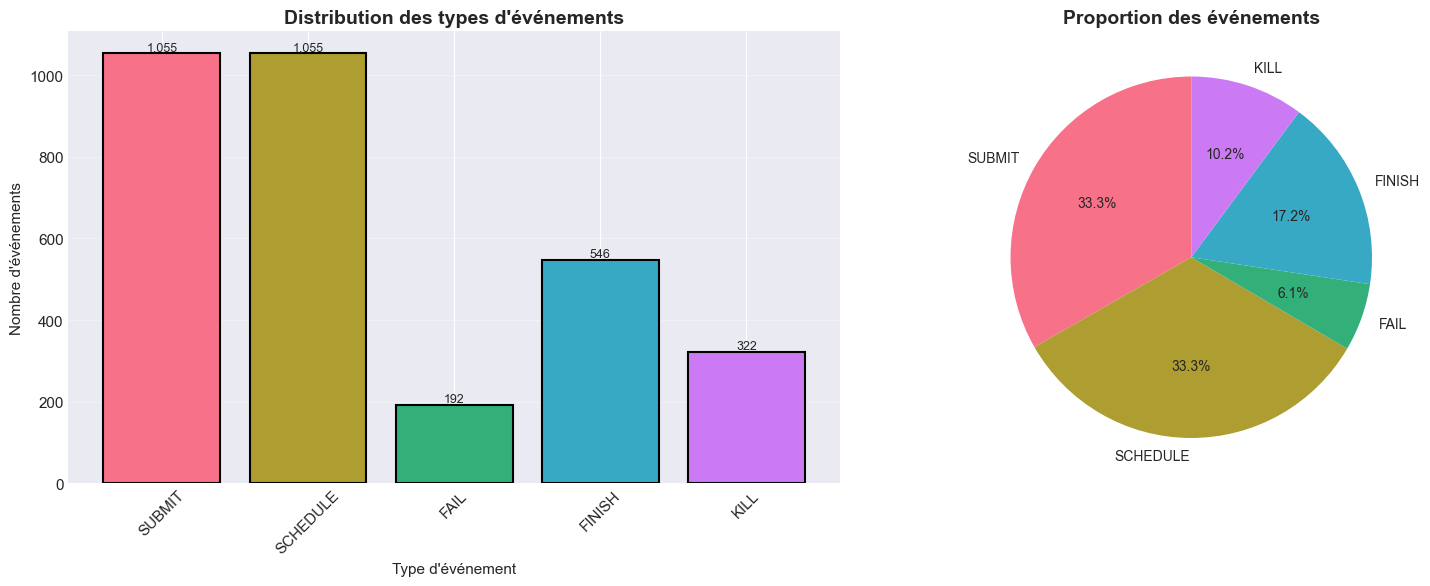

✅ Figure sauvegardée: ../results/figures/event_type_distribution.png


In [41]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique à barres
ax1 = axes[0]
event_names = [EVENT_TYPES[e] for e in event_counts.index]
colors = sns.color_palette("husl", len(event_counts))

bars = ax1.bar(event_names, event_counts.values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_title('Distribution des types d\'événements', fontsize=14, fontweight='bold')
ax1.set_xlabel('Type d\'événement')
ax1.set_ylabel('Nombre d\'événements')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

# Camembert
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    event_counts.values,
    labels=event_names,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 10}
)
ax2.set_title('Proportion des événements', fontsize=14, fontweight='bold')

plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/event_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: ../results/figures/event_type_distribution.png")

### 4.2 Focus sur les événements clés

In [42]:
# Extraire les événements principaux
submit_events = df_sample[df_sample['event_type'] == 0]  # SUBMIT
finish_events = df_sample[df_sample['event_type'] == 4]  # FINISH
fail_events = df_sample[df_sample['event_type'] == 3]    # FAIL
evict_events = df_sample[df_sample['event_type'] == 2]   # EVICT
lost_events = df_sample[df_sample['event_type'] == 6]    # LOST

print("Événements clés:\n")
print(f"📥 SUBMIT (arrivées):  {len(submit_events):>8,} événements")
print(f"✅ FINISH (succès):    {len(finish_events):>8,} événements")
print(f"❌ FAIL (échecs):      {len(fail_events):>8,} événements")
print(f"⏸️  EVICT (préemption): {len(evict_events):>8,} événements")
print(f"💔 LOST (perdus):      {len(lost_events):>8,} événements")

# Taux de réussite/échec
if len(submit_events) > 0:
    success_rate = len(finish_events) / len(submit_events) * 100
    failure_rate = len(fail_events) / len(submit_events) * 100
    eviction_rate = len(evict_events) / len(submit_events) * 100
    
    print(f"\n📊 Statistiques (par rapport aux SUBMIT):")
    print(f"  Taux de succès:    {success_rate:>6.2f}%")
    print(f"  Taux d'échec:      {failure_rate:>6.2f}%")
    print(f"  Taux de préemption: {eviction_rate:>6.2f}%")

Événements clés:

📥 SUBMIT (arrivées):     1,055 événements
✅ FINISH (succès):         546 événements
❌ FAIL (échecs):           192 événements
⏸️  EVICT (préemption):        0 événements
💔 LOST (perdus):             0 événements

📊 Statistiques (par rapport aux SUBMIT):
  Taux de succès:     51.75%
  Taux d'échec:       18.20%
  Taux de préemption:   0.00%


## 5. Analyse des arrivées de jobs (SUBMIT)

### 5.1 Série temporelle des arrivées

In [43]:
# Extraire les arrivées
arrivals = df_sample[df_sample['event_type'] == 0].copy()
arrivals = arrivals.sort_values('timestamp')

print(f"📥 Arrivées de jobs: {len(arrivals):,}")
print(f"   Jobs uniques: {arrivals['job_id'].nunique():,}")
print(f"   Période: {arrivals['datetime'].min()} → {arrivals['datetime'].max()}")

# Afficher quelques arrivées
arrivals[['job_id', 'timestamp', 'datetime']].head(10)

📥 Arrivées de jobs: 1,055
   Jobs uniques: 1,055
   Période: 1970-01-29 21:23:00.497145 → 1970-01-29 22:46:18.763836


,job_id,timestamp,datetime
0,6485654939,2496180497145,1970-01-29 21:23:00.497145
1,6485659762,2496181897961,1970-01-29 21:23:01.897961
2,6485662004,2496183627940,1970-01-29 21:23:03.627940
3,6485662008,2496183668496,1970-01-29 21:23:03.668496
4,6485662028,2496184512822,1970-01-29 21:23:04.512822
7,6485688741,2496192263778,1970-01-29 21:23:12.263778
12,6485688840,2496195649631,1970-01-29 21:23:15.649631
19,6485662006,2496199437967,1970-01-29 21:23:19.437967
21,6485689144,2496201257878,1970-01-29 21:23:21.257878
24,6485689375,2496208976117,1970-01-29 21:23:28.976117


In [44]:
# Compter les arrivées par différents intervalles de temps
arrivals_1min = arrivals.set_index('datetime').resample('1min').size()
arrivals_10min = arrivals.set_index('datetime').resample('10min').size()
arrivals_1h = arrivals.set_index('datetime').resample('1H').size()

print("Statistiques des arrivées:\n")

print("Par minute:")
print(f"  Moyenne: {arrivals_1min.mean():.2f}")
print(f"  Médiane: {arrivals_1min.median():.2f}")
print(f"  Max:     {arrivals_1min.max():.0f}")

print("\nPar 10 minutes:")
print(f"  Moyenne: {arrivals_10min.mean():.2f}")
print(f"  Médiane: {arrivals_10min.median():.2f}")
print(f"  Max:     {arrivals_10min.max():.0f}")

print("\nPar heure:")
print(f"  Moyenne: {arrivals_1h.mean():.2f}")
print(f"  Médiane: {arrivals_1h.median():.2f}")
print(f"  Max:     {arrivals_1h.max():.0f}")

Statistiques des arrivées:

Par minute:
  Moyenne: 12.56
  Médiane: 11.00
  Max:     42

Par 10 minutes:
  Moyenne: 117.22
  Médiane: 105.00
  Max:     178

Par heure:
  Moyenne: 527.50
  Médiane: 527.50
  Max:     630


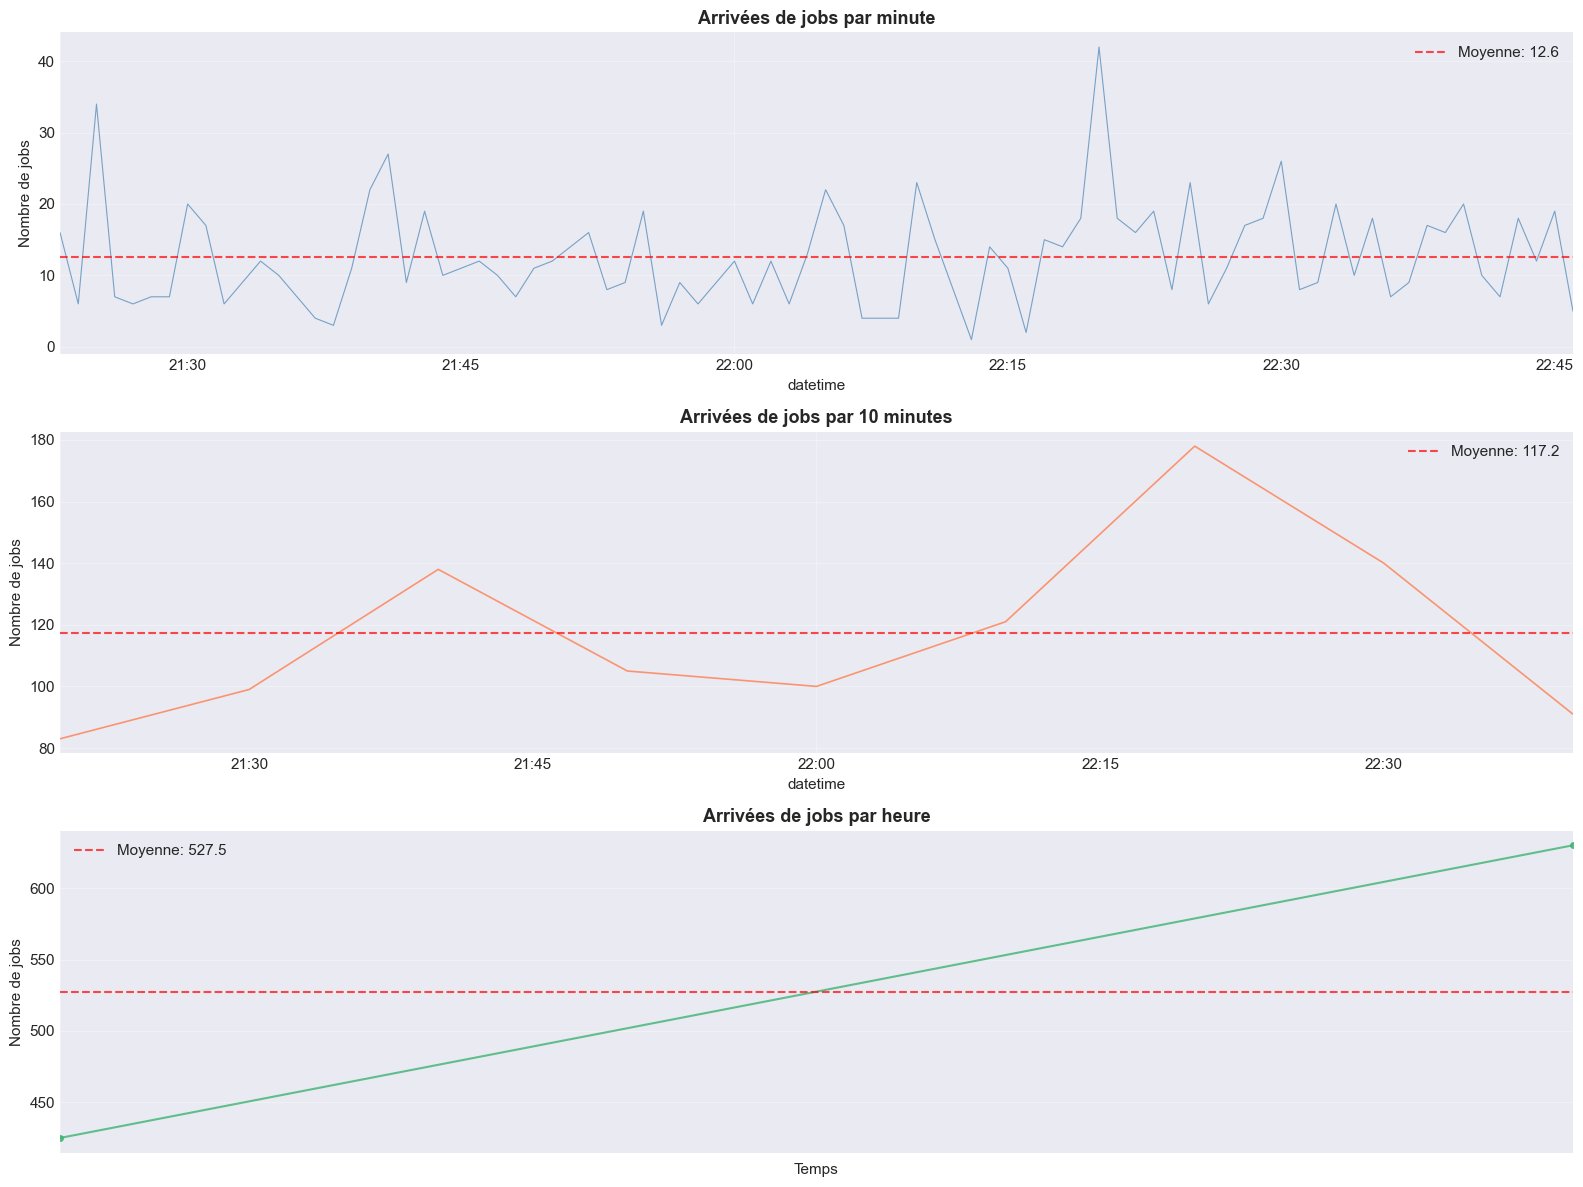

✅ Figure sauvegardée: ../results/figures/arrivals_temporal_series.png


In [45]:
# Visualisation des arrivées
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Par minute
ax1 = axes[0]
arrivals_1min.plot(ax=ax1, linewidth=0.8, color='steelblue', alpha=0.7)
ax1.set_title('Arrivées de jobs par minute', fontsize=13, fontweight='bold')
ax1.set_ylabel('Nombre de jobs')
ax1.grid(True, alpha=0.3)
ax1.axhline(arrivals_1min.mean(), color='red', linestyle='--', 
           label=f'Moyenne: {arrivals_1min.mean():.1f}', alpha=0.7)
ax1.legend()

# Par 10 minutes
ax2 = axes[1]
arrivals_10min.plot(ax=ax2, linewidth=1.2, color='coral', alpha=0.8)
ax2.set_title('Arrivées de jobs par 10 minutes', fontsize=13, fontweight='bold')
ax2.set_ylabel('Nombre de jobs')
ax2.grid(True, alpha=0.3)
ax2.axhline(arrivals_10min.mean(), color='red', linestyle='--',
           label=f'Moyenne: {arrivals_10min.mean():.1f}', alpha=0.7)
ax2.legend()

# Par heure
ax3 = axes[2]
arrivals_1h.plot(ax=ax3, linewidth=1.5, color='mediumseagreen', alpha=0.8, marker='o', markersize=4)
ax3.set_title('Arrivées de jobs par heure', fontsize=13, fontweight='bold')
ax3.set_xlabel('Temps')
ax3.set_ylabel('Nombre de jobs')
ax3.grid(True, alpha=0.3)
ax3.axhline(arrivals_1h.mean(), color='red', linestyle='--',
           label=f'Moyenne: {arrivals_1h.mean():.1f}', alpha=0.7)
ax3.legend()

plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/arrivals_temporal_series.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: ../results/figures/arrivals_temporal_series.png")

### 5.2 Histogramme des arrivées

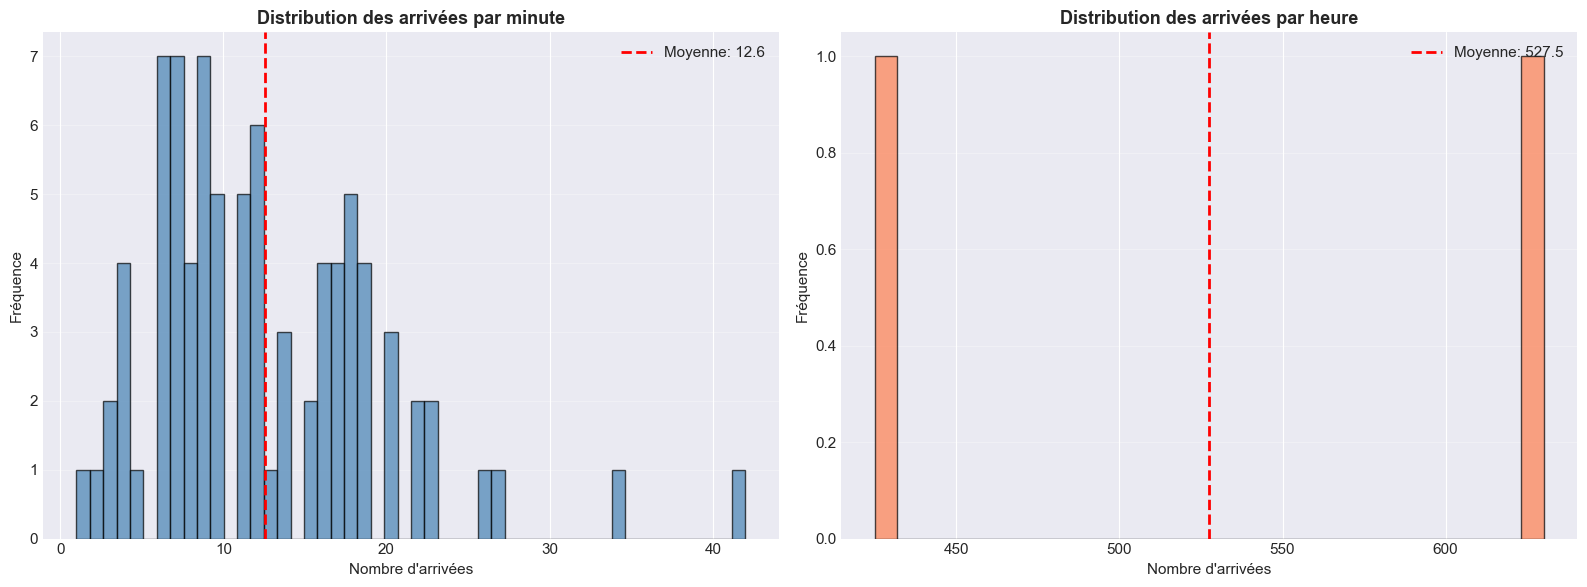

✅ Figure sauvegardée: ../results/figures/arrivals_histograms.png


In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme par minute
ax1 = axes[0]
arrivals_1min[arrivals_1min > 0].hist(bins=50, ax=ax1, color='steelblue', 
                                       edgecolor='black', alpha=0.7)
ax1.set_title('Distribution des arrivées par minute', fontsize=13, fontweight='bold')
ax1.set_xlabel('Nombre d\'arrivées')
ax1.set_ylabel('Fréquence')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axvline(arrivals_1min.mean(), color='red', linestyle='--', 
           label=f'Moyenne: {arrivals_1min.mean():.1f}', linewidth=2)
ax1.legend()

# Histogramme par heure
ax2 = axes[1]
arrivals_1h[arrivals_1h > 0].hist(bins=30, ax=ax2, color='coral',
                                  edgecolor='black', alpha=0.7)
ax2.set_title('Distribution des arrivées par heure', fontsize=13, fontweight='bold')
ax2.set_xlabel('Nombre d\'arrivées')
ax2.set_ylabel('Fréquence')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axvline(arrivals_1h.mean(), color='red', linestyle='--',
           label=f'Moyenne: {arrivals_1h.mean():.1f}', linewidth=2)
ax2.legend()

plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/arrivals_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: ../results/figures/arrivals_histograms.png")

### 5.3 Pattern journalier et hebdomadaire

In [ ]:
# Extraire les composantes temporelles
arrivals['hour'] = arrivals['datetime'].dt.hour
arrivals['day_of_week'] = arrivals['datetime'].dt.dayofweek
arrivals['date'] = arrivals['datetime'].dt.date

# Pattern horaire
hourly_pattern = arrivals.groupby('hour').size()
hourly_pattern = hourly_pattern.reindex(range(24), fill_value=0)  # Assurer tous les heures 0-23

# Pattern hebdomadaire
days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
weekly_pattern = arrivals.groupby('day_of_week').size()
weekly_pattern = weekly_pattern.reindex(range(7), fill_value=0)  # Assurer tous les jours 0-6

print("Pattern journalier (par heure):\n")
for hour, count in hourly_pattern.items():
    print(f"  {hour:2d}h: {count:>6,} arrivées")

print("\nPattern hebdomadaire:\n")
for day_idx, count in weekly_pattern.items():
    print(f"  {days[day_idx]:10s}: {count:>6,} arrivées")

Pattern journalier (par heure):

  21h:    425 arrivées
  22h:    630 arrivées

Pattern hebdomadaire:

  Jeudi     :  1,055 arrivées


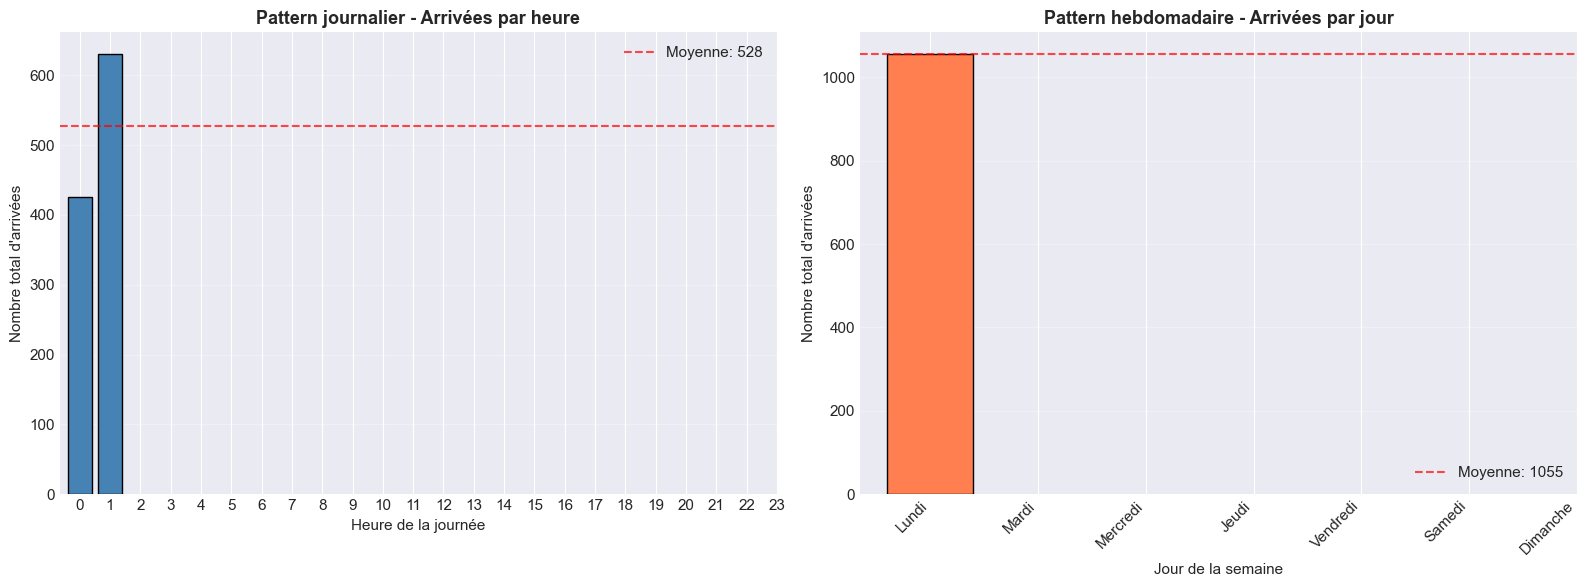

✅ Figure sauvegardée: ../results/figures/arrivals_patterns.png


In [60]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pattern horaire
ax1 = axes[0]
hourly_pattern.plot(kind='bar', ax=ax1, color='steelblue', 
                    edgecolor='black', width=0.8)
ax1.set_title('Pattern journalier - Arrivées par heure', 
             fontsize=13, fontweight='bold')
ax1.set_xlabel('Heure de la journée')
ax1.set_ylabel('Nombre total d\'arrivées')
ax1.set_xticks(range(24))
ax1.set_xticklabels(range(24), rotation=0)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(hourly_pattern.mean(), color='red', linestyle='--',
           label=f'Moyenne: {hourly_pattern.mean():.0f}', alpha=0.7)
ax1.legend()

# Pattern hebdomadaire
ax2 = axes[1]
weekly_pattern.plot(kind='bar', ax=ax2, color='coral',
                   edgecolor='black', width=0.8)
ax2.set_title('Pattern hebdomadaire - Arrivées par jour',
             fontsize=13, fontweight='bold')
ax2.set_xlabel('Jour de la semaine')
ax2.set_ylabel('Nombre total d\'arrivées')
ax2.set_xticks(range(7))
ax2.set_xticklabels(days, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(weekly_pattern.mean(), color='red', linestyle='--',
           label=f'Moyenne: {weekly_pattern.mean():.0f}', alpha=0.7)
ax2.legend()

plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/arrivals_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: ../results/figures/arrivals_patterns.png")

### 5.4 Heatmap jour × heure

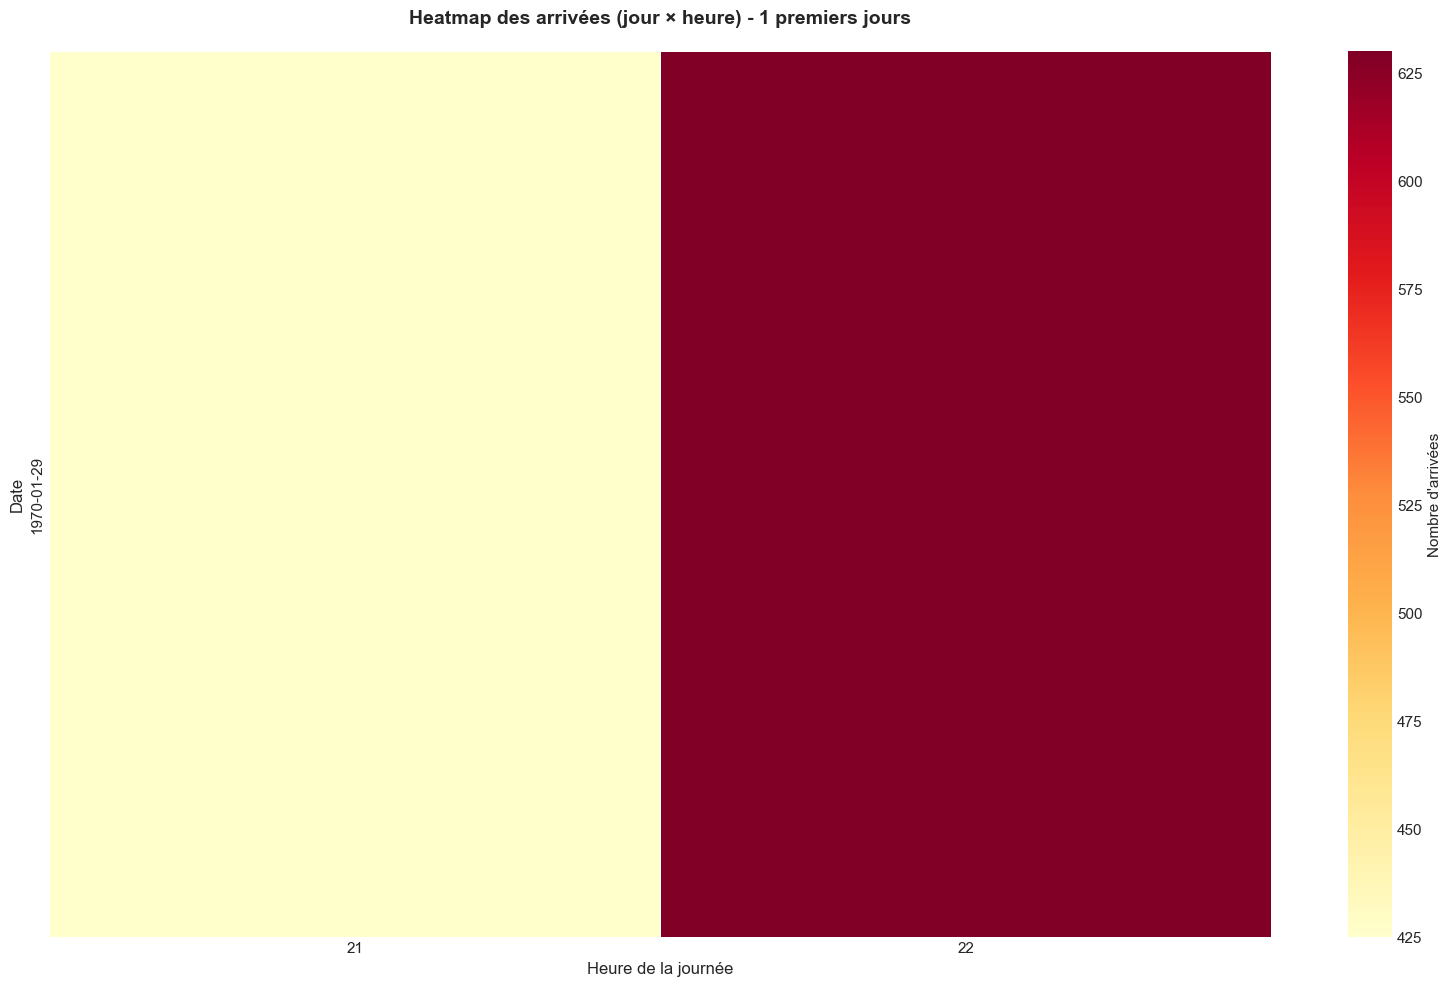

✅ Figure sauvegardée: ../results/figures/arrivals_heatmap.png


In [49]:
# Créer une matrice jour × heure
daily_hourly = arrivals.groupby(['date', 'hour']).size().reset_index(name='count')
pivot_table = daily_hourly.pivot_table(values='count', 
                                       index='date', 
                                       columns='hour',
                                       fill_value=0)

# Limiter aux premiers jours pour lisibilité
n_days = min(30, len(pivot_table))
pivot_subset = pivot_table.iloc[:n_days]

# Heatmap
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(pivot_subset, 
           cmap='YlOrRd',
           ax=ax,
           cbar_kws={'label': 'Nombre d\'arrivées'},
           linewidths=0.5,
           linecolor='white')

ax.set_title(f'Heatmap des arrivées (jour × heure) - {n_days} premiers jours',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Heure de la journée', fontsize=12)
ax.set_ylabel('Date', fontsize=12)

plt.tight_layout()
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/arrivals_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: ../results/figures/arrivals_heatmap.png")

## 6. Analyse du cycle de vie des jobs

### 6.1 Tracer quelques jobs individuels

In [50]:
# Jobs qui ont plusieurs événements
job_event_counts = df_sample.groupby('job_id').size()
jobs_with_multiple_events = job_event_counts[job_event_counts > 1].index[:10]

print(f"Jobs avec plusieurs événements (10 premiers):\n")

for job_id in jobs_with_multiple_events:
    job_events = df_sample[df_sample['job_id'] == job_id].sort_values('timestamp')
    
    print(f"\nJob {job_id}:")
    for _, event in job_events.iterrows():
        event_name = EVENT_TYPES[event['event_type']]
        print(f"  {event['datetime']} - {event_name}")
    
    # Durée totale
    duration = job_events['datetime'].max() - job_events['datetime'].min()
    print(f"  Durée totale: {duration}")

Jobs avec plusieurs événements (10 premiers):


Job 6485372523:
  1970-01-29 22:33:56.995032 - SUBMIT
  1970-01-29 22:33:58.406304 - SCHEDULE
  1970-01-29 22:35:01.451348 - FINISH
  Durée totale: 0 days 00:01:04.456316

Job 6485411725:
  1970-01-29 21:53:45.372236 - SUBMIT
  1970-01-29 21:53:46.813417 - SCHEDULE
  Durée totale: 0 days 00:00:01.441181

Job 6485411759:
  1970-01-29 21:53:45.372237 - SUBMIT
  1970-01-29 21:53:46.813452 - SCHEDULE
  Durée totale: 0 days 00:00:01.441215

Job 6485654939:
  1970-01-29 21:23:00.497145 - SUBMIT
  1970-01-29 21:23:05.323314 - SCHEDULE
  1970-01-29 21:40:58.501893 - KILL
  Durée totale: 0 days 00:17:58.004748

Job 6485659762:
  1970-01-29 21:23:01.897961 - SUBMIT
  1970-01-29 21:23:16.322830 - SCHEDULE
  1970-01-29 21:40:58.536124 - KILL
  Durée totale: 0 days 00:17:56.638163

Job 6485662004:
  1970-01-29 21:23:03.627940 - SUBMIT
  1970-01-29 21:23:16.322777 - SCHEDULE
  1970-01-29 21:44:01.829111 - FINISH
  Durée totale: 0 days 00:20:58.201171



### 6.2 Statistiques des transitions

In [51]:
# Analyser les transitions d'événements
df_sorted = df_sample.sort_values(['job_id', 'timestamp'])
df_sorted['next_event'] = df_sorted.groupby('job_id')['event_type'].shift(-1)

# Supprimer les NaN (derniers événements de chaque job)
transitions = df_sorted.dropna(subset=['next_event'])
transitions['next_event'] = transitions['next_event'].astype(int)

# Créer une matrice de transition
transition_matrix = pd.crosstab(
    transitions['event_type'].map(EVENT_TYPES),
    transitions['next_event'].map(EVENT_TYPES),
    normalize='index'
) * 100

print("Matrice de transition (% de probabilité):\n")
print(transition_matrix.round(1))

Matrice de transition (% de probabilité):

next_event  FAIL  FINISH  KILL  SCHEDULE
event_type                              
SCHEDULE    19.4    51.7  28.9       0.0
SUBMIT       0.0     0.0   0.0     100.0


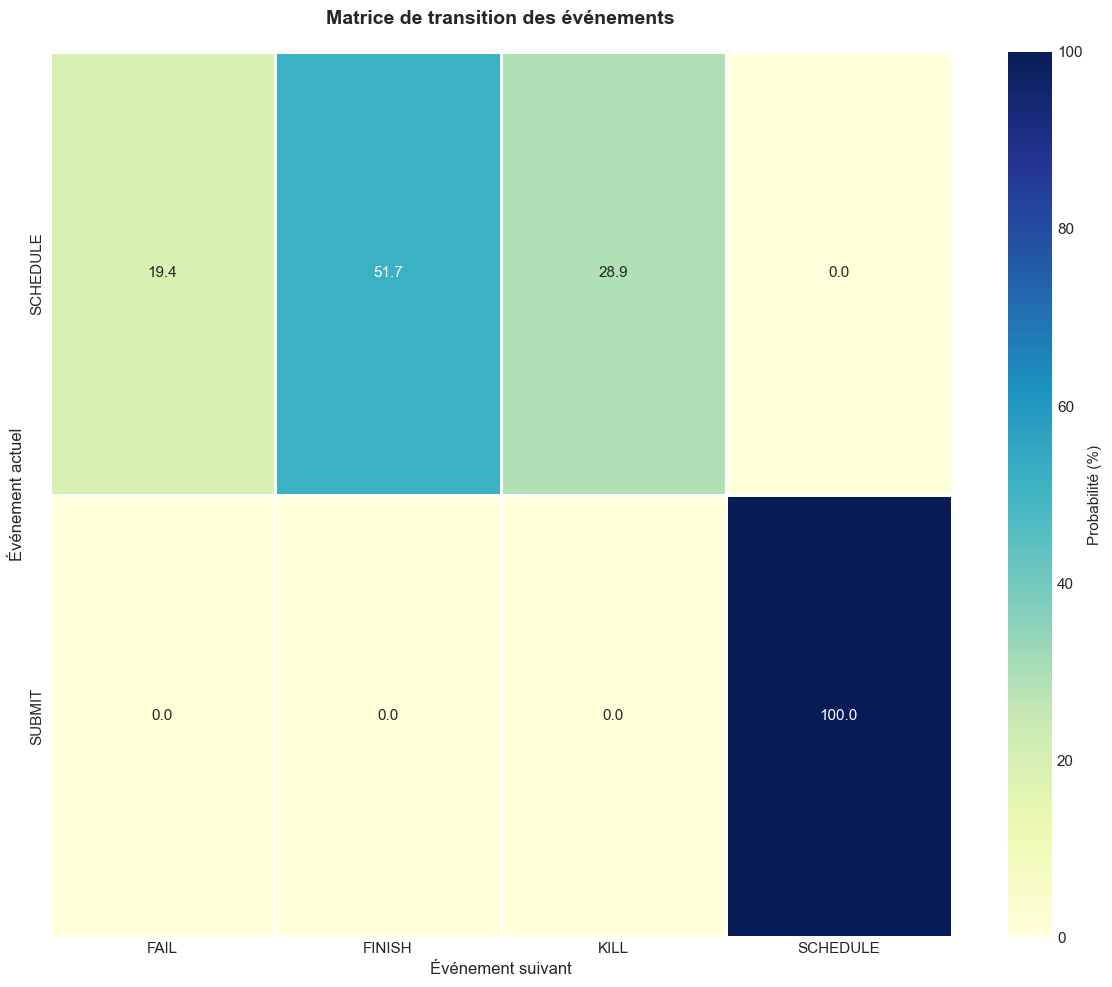

✅ Figure sauvegardée: ../results/figures/transition_matrix.png


In [54]:
# Heatmap des transitions
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(transition_matrix,
           annot=True,
           fmt='.1f',
           cmap='YlGnBu',
           ax=ax,
           cbar_kws={'label': 'Probabilité (%)'},
           linewidths=1,
           linecolor='white')

ax.set_title('Matrice de transition des événements',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Événement suivant', fontsize=12)
ax.set_ylabel('Événement actuel', fontsize=12)

plt.tight_layout()
plt.savefig('../results/figures/transition_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure sauvegardée: ../results/figures/transition_matrix.png")

## 7. Chargement de plusieurs fichiers

In [55]:
def load_multiple_files(files, max_files=10, rows_per_file=50000):
    """
    Charge plusieurs fichiers et consolide.
    """
    all_data = []
    
    print(f"Chargement de {max_files} fichiers ({rows_per_file:,} lignes par fichier)...\n")
    
    for i, filepath in enumerate(files[:max_files], 1):
        print(f"[{i}/{max_files}] {filepath.name}")
        
        df = load_sample(filepath, n_rows=rows_per_file)
        
        if not df.empty:
            all_data.append(df)
            print(f"  ✓ {len(df):,} lignes chargées")
    
    # Consolider
    print("\nConsolidation...")
    result = pd.concat(all_data, ignore_index=True)
    
    # Convertir timestamps
    result['datetime'] = pd.to_datetime(result['timestamp'], unit='us', errors='coerce')
    result['event_name'] = result['event_type'].map(EVENT_TYPES)
    
    print(f"\n✅ Total: {len(result):,} événements")
    print(f"   Jobs uniques: {result['job_id'].nunique():,}")
    print(f"   Période: {result['datetime'].min()} → {result['datetime'].max()}")
    
    return result

# Charger 10 fichiers
df_large = load_multiple_files(files, max_files=10, rows_per_file=50000)

Chargement de 10 fichiers (50,000 lignes par fichier)...

[1/10] part-00000-of-00500.csv.gz
  ✓ 10,704 lignes chargées
[2/10] part-00001-of-00500.csv.gz
  ✓ 3,099 lignes chargées
[3/10] part-00002-of-00500.csv.gz
  ✓ 3,360 lignes chargées
[4/10] part-00003-of-00500.csv.gz
  ✓ 4,179 lignes chargées
[5/10] part-00004-of-00500.csv.gz
  ✓ 4,095 lignes chargées
[6/10] part-00005-of-00500.csv.gz
  ✓ 3,033 lignes chargées
[7/10] part-00006-of-00500.csv.gz
  ✓ 2,451 lignes chargées
[8/10] part-00007-of-00500.csv.gz
  ✓ 2,698 lignes chargées
[9/10] part-00008-of-00500.csv.gz
  ✓ 2,911 lignes chargées
[10/10] part-00009-of-00500.csv.gz
  ✓ 2,905 lignes chargées

Consolidation...

✅ Total: 39,435 événements
   Jobs uniques: 14,489
   Période: 1970-01-01 00:00:00 → 1970-01-01 14:05:10.294465


In [56]:
# Statistiques sur le dataset élargi
print("Statistiques du dataset élargi:\n")
print("="*60)
print(f"Total événements:     {len(df_large):>12,}")
print(f"Jobs uniques:         {df_large['job_id'].nunique():>12,}")
print(f"Période:              {df_large['datetime'].min()}")
print(f"                   → {df_large['datetime'].max()}")
print(f"Durée:                {df_large['datetime'].max() - df_large['datetime'].min()}")
print("="*60)

print("\nDistribution des événements:\n")
event_dist = df_large['event_name'].value_counts()
for event_name, count in event_dist.items():
    pct = count / len(df_large) * 100
    print(f"  {event_name:20s}: {count:>12,} ({pct:>5.2f}%)")

Statistiques du dataset élargi:

Total événements:           39,435
Jobs uniques:               14,489
Période:              1970-01-01 00:00:00
                   → 1970-01-01 14:05:10.294465
Durée:                0 days 14:05:10.294465

Distribution des événements:

  SUBMIT              :       14,490 (36.74%)
  SCHEDULE            :       14,480 (36.72%)
  FINISH              :        6,835 (17.33%)
  KILL                :        3,498 ( 8.87%)
  FAIL                :          132 ( 0.33%)


## 8. Sauvegarde des arrivées pour analyse ultérieure

In [59]:
# Extraire et sauvegarder les arrivées
arrivals_large = df_large[df_large['event_type'] == 0].copy()
arrivals_large = arrivals_large.sort_values('timestamp')

# Sauvegarder
output_path = '../data/processed/2011_arrivals_sample.csv'
arrivals_large[['job_id', 'timestamp', 'datetime']].to_csv(output_path, index=False)

print(f"✅ Arrivées sauvegardées: {output_path}")
print(f"   {len(arrivals_large):,} arrivées")
print(f"   {arrivals_large['job_id'].nunique():,} jobs uniques")

✅ Arrivées sauvegardées: ../data/processed/2011_arrivals_sample.csv
   14,490 arrivées
   14,489 jobs uniques


## 9. Résumé et conclusions

In [58]:
print("="*70)
print("RÉSUMÉ DE L'EXPLORATION")
print("="*70)

print("\n📊 Dataset:")
print(f"  • Fichiers analysés: {len(files)} disponibles")
print(f"  • Événements chargés: {len(df_large):,}")
print(f"  • Jobs uniques: {df_large['job_id'].nunique():,}")

print("\n📥 Arrivées (SUBMIT):")
arrivals_stats = arrivals_large.set_index('datetime').resample('1H').size()
print(f"  • Total arrivées: {len(arrivals_large):,}")
print(f"  • Moyenne/heure: {arrivals_stats.mean():.2f}")
print(f"  • Max/heure: {arrivals_stats.max():.0f}")

print("\n🎯 Types d'événements:")
for event_name in ['SUBMIT', 'FINISH', 'FAIL', 'EVICT']:
    count = (df_large['event_name'] == event_name).sum()
    pct = count / len(df_large) * 100
    print(f"  • {event_name:10s}: {count:>10,} ({pct:>5.2f}%)")

print("\n💾 Fichiers générés:")
print("  • results/figures/event_type_distribution.png")
print("  • results/figures/arrivals_temporal_series.png")
print("  • results/figures/arrivals_histograms.png")
print("  • results/figures/arrivals_patterns.png")
print("  • results/figures/arrivals_heatmap.png")
print("  • results/figures/transition_matrix.png")
print("  • data/processed/2011_arrivals_sample.csv")

print("\n🚀 Prochaines étapes:")
print("  1. Charger tous les fichiers (500) pour dataset complet")
print("  2. Créer les séquences temporelles pour le VAE")
print("  3. Analyser l'incertitude (boîtes, polytopes, Wasserstein)")
print("  4. Entraîner le modèle VAE-LSTM")
print("="*70)

RÉSUMÉ DE L'EXPLORATION

📊 Dataset:
  • Fichiers analysés: 500 disponibles
  • Événements chargés: 39,435
  • Jobs uniques: 14,489

📥 Arrivées (SUBMIT):
  • Total arrivées: 14,490
  • Moyenne/heure: 966.00
  • Max/heure: 4552

🎯 Types d'événements:
  • SUBMIT    :     14,490 (36.74%)
  • FINISH    :      6,835 (17.33%)
  • FAIL      :        132 ( 0.33%)
  • EVICT     :          0 ( 0.00%)

💾 Fichiers générés:
  • results/figures/event_type_distribution.png
  • results/figures/arrivals_temporal_series.png
  • results/figures/arrivals_histograms.png
  • results/figures/arrivals_patterns.png
  • results/figures/arrivals_heatmap.png
  • results/figures/transition_matrix.png
  • data/processed/2011_arrivals_sample.csv

🚀 Prochaines étapes:
  1. Charger tous les fichiers (500) pour dataset complet
  2. Créer les séquences temporelles pour le VAE
  3. Analyser l'incertitude (boîtes, polytopes, Wasserstein)
  4. Entraîner le modèle VAE-LSTM
